# Mini-projet n°3 - ViT vs CNN

L'objectif de ce mini-projet est de comparer les performances de deux architectures différentes pour de la classification d'image : les Vision Transformers (ViT) et les Convolutional Neural Networks (CNN).

# Choix des deux datasets

Nous avons sélectionné deux datasets pour comparer les performances de classification entre un Vision Transformer (ViT) et un réseau de neurones convolutif (CNN). Le premier est un dataset contenant des photos de personnes exprimant une émotion, et sont labellisés dans cinq catégories différentes: 'angry' (la colère), 'sad' (la tristesse), 'surprise' (la surprise, sans surprise), 'happy' (la joie) et 'fear' (la peur). Nous avons choisi ce premier data set car il était très complet et nous avons remarqué que les ViT étaient efficaces sur des datasets larges (ce que nous cherchons en partie à tester aujourd'hui), mais également car nous avons considéré que de par la différence d'expression des sentiments selon les personnes, cela serait intéressant d'étudier la classification faite par l'ordinateur de deux manières différentes. Aussi, nous adorons le film Vice-Versa.

Nous avons également sélectionné un dataset de fleurs labellisés en 'daisy', 'dandelion', 'rose', 'sunflower', 'tulip'. Ce datset est également large mais environ trois fois moins que le précédent. 

## Analyse exploratoire

In [29]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
import torch.optim as optim
from tqdm import tqdm
import time

In [2]:
#Pour le ViT
from torchvision.models import vit_b_16, ViT_B_16_Weights
from timm import create_model

In [3]:
def summarize_dataset(root_dir):
    classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
    stats = {}

    for cls in classes:
        cls_path = os.path.join(root_dir, cls)
        imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(("jpg","jpeg","png"))]
        stats[cls] = len(imgs)

    return pd.DataFrame({"Classe": list(stats.keys()), "Nombre d'images": list(stats.values())})

df_emotions = summarize_dataset("emotions/Data")
df_fleurs = summarize_dataset("fleurs/train")

df_emotions, df_fleurs

(    Classe  Nombre d'images
 0    Angry            10148
 1     Fear             9732
 2    Happy            18439
 3      Sad            12553
 4  Suprise             8227,
       Classe  Nombre d'images
 0      daisy              501
 1  dandelion              646
 2       rose              497
 3  sunflower              495
 4      tulip              607)

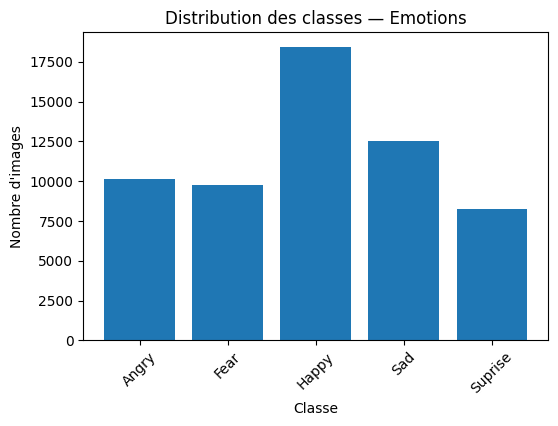

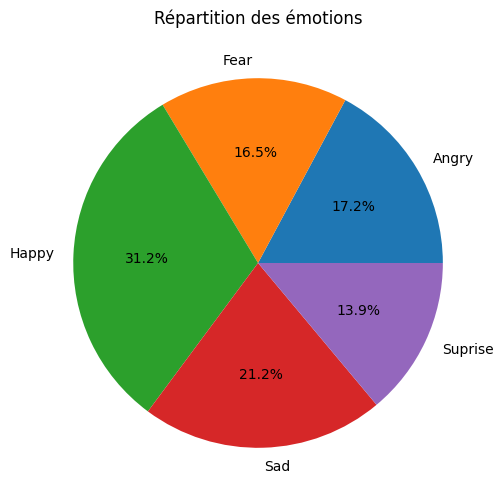

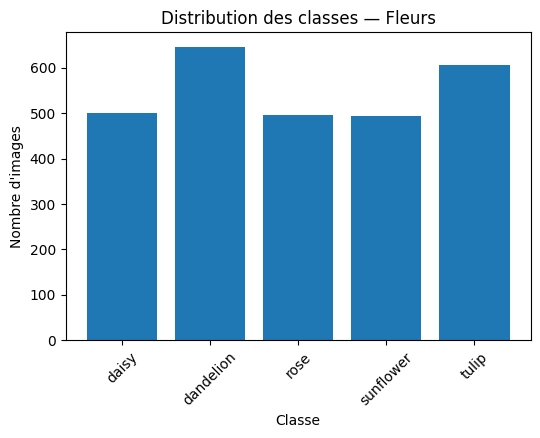

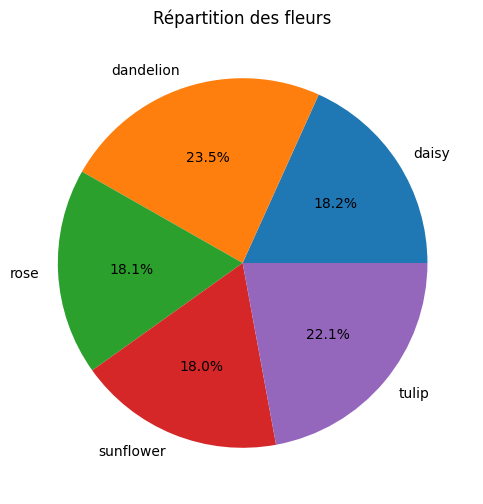

In [15]:
def count_images(root):
    classes = sorted(os.listdir(root))
    return {cls: len([f for f in os.listdir(os.path.join(root, cls)) 
                      if f.lower().endswith(("jpg","png","jpeg"))]) 
            for cls in classes}

# Comptage des images
emotion_counts = count_images("emotions/Data")

# Barplot
plt.figure(figsize=(6,4))
plt.bar(emotion_counts.keys(), emotion_counts.values())
plt.title("Distribution des classes — Emotions")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=45)
plt.show()

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(emotion_counts.values(), labels=emotion_counts.keys(), autopct='%1.1f%%')
plt.title("Répartition des émotions")
plt.show()

flower_counts = count_images("fleurs/train")

# Barplot
plt.figure(figsize=(6,4))
plt.bar(flower_counts.keys(), flower_counts.values())
plt.title("Distribution des classes — Fleurs")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=45)
plt.show()

# Pie Chart
plt.figure(figsize=(6,6))
plt.pie(flower_counts.values(), labels=flower_counts.keys(), autopct='%1.1f%%')
plt.title("Répartition des fleurs")
plt.show()

### Etude de la qualité des images: résolution, dimensions, luminosité

In [16]:
def check_images(folder):
    corrupted = []
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                path = os.path.join(root, f)
                try:
                    img = Image.open(path)
                    img.verify()  # vérifie l'intégrité
                except Exception:
                    corrupted.append(path)
    print(f"{len(corrupted)} images corrompues trouvées")
    return corrupted

#corrupted_files = check_images("emotions/Data")

def small_image_stats(folder, min_width=128, min_height=128):
    total_images = 0
    small_images = 0
    
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                total_images += 1
                path = os.path.join(root, f)
                try:
                    img = Image.open(path)
                    w, h = img.size
                    if w < min_width or h < min_height:
                        small_images += 1
                except:
                    # Ignorer les images corrompues
                    pass
    
    if total_images == 0:
        print("Aucune image trouvée !")
        return
    
    percent = (small_images / total_images) * 100
    print(f"Images totales : {total_images}")
    print(f"Images plus petites que {min_width}x{min_height} : {small_images} ({percent:.2f}%)")
    return total_images, small_images, percent

small_image_stats("emotions/Data")
small_image_stats("fleurs/Data")

Images totales : 59099
Images plus petites que 128x128 : 57781 (97.77%)
Aucune image trouvée !


In [11]:
def resolution_stats(root_dir):
    widths, heights = [], []

    for cls in os.listdir(root_dir):
        cls_path = os.path.join(root_dir, cls)
        imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(("jpg","jpeg","png"))]

        for img_name in imgs:
            img = Image.open(os.path.join(cls_path, img_name))
            w, h = img.size
            widths.append(w)
            heights.append(h)

    df = pd.DataFrame({"width": widths, "height": heights})
    return df

df_res_emotions = resolution_stats("emotions/Data")
#df_res_fleurs = resolution_stats("fleurs/train")

df_res_emotions.describe(), 
#df_res_fleurs.describe()

(              width        height
 count  59099.000000  59099.000000
 mean      80.886056     80.393611
 std      336.623670    335.071391
 min       48.000000     48.000000
 25%       48.000000     48.000000
 50%       48.000000     48.000000
 75%       48.000000     48.000000
 max     8957.000000   8660.000000,)

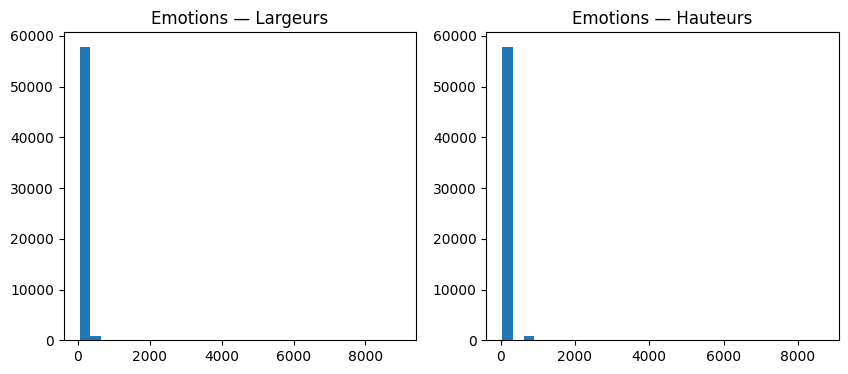

In [12]:
def plot_res_hist(df, title):
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.hist(df["width"], bins=30)
    plt.title(title + " — Largeurs")

    plt.subplot(1,2,2)
    plt.hist(df["height"], bins=30)
    plt.title(title + " — Hauteurs")

    plt.show()

plot_res_hist(df_res_emotions, "Emotions")
#plot_res_hist(df_res_fleurs, "Fleurs")

# a quoi ca sert ?

### Affichage de quelques images représentatives :

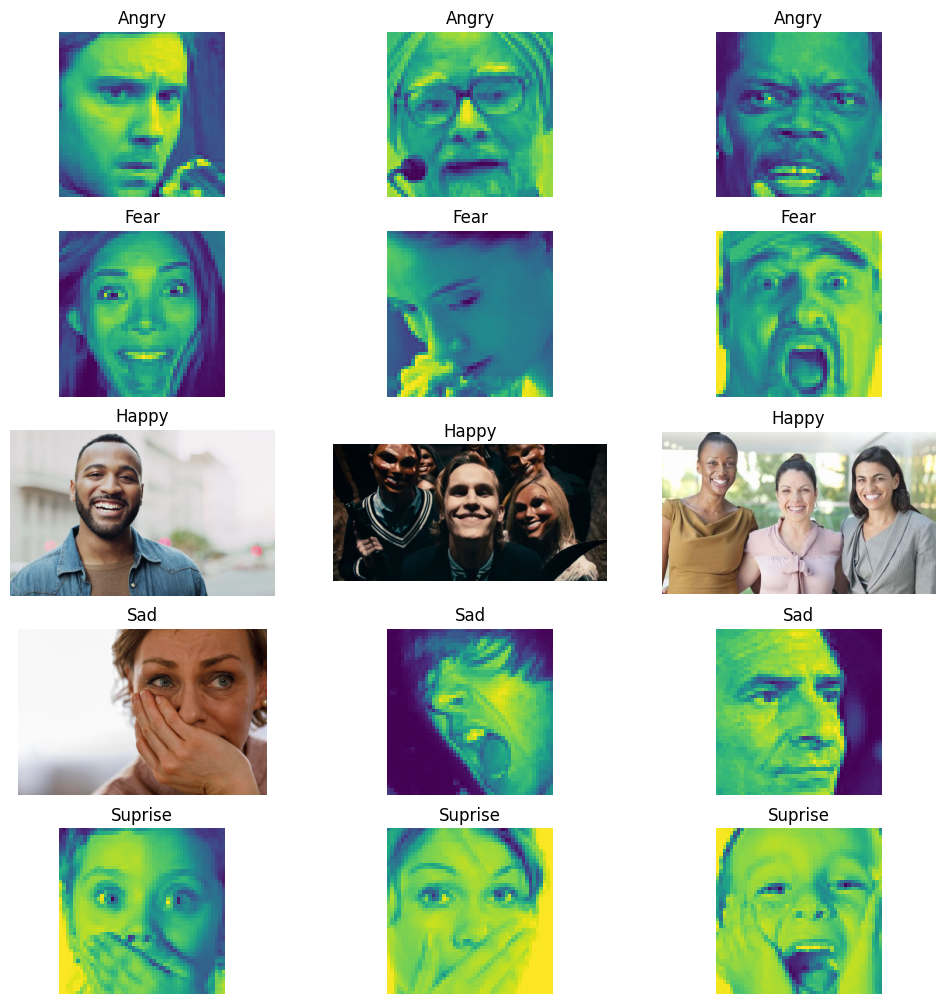

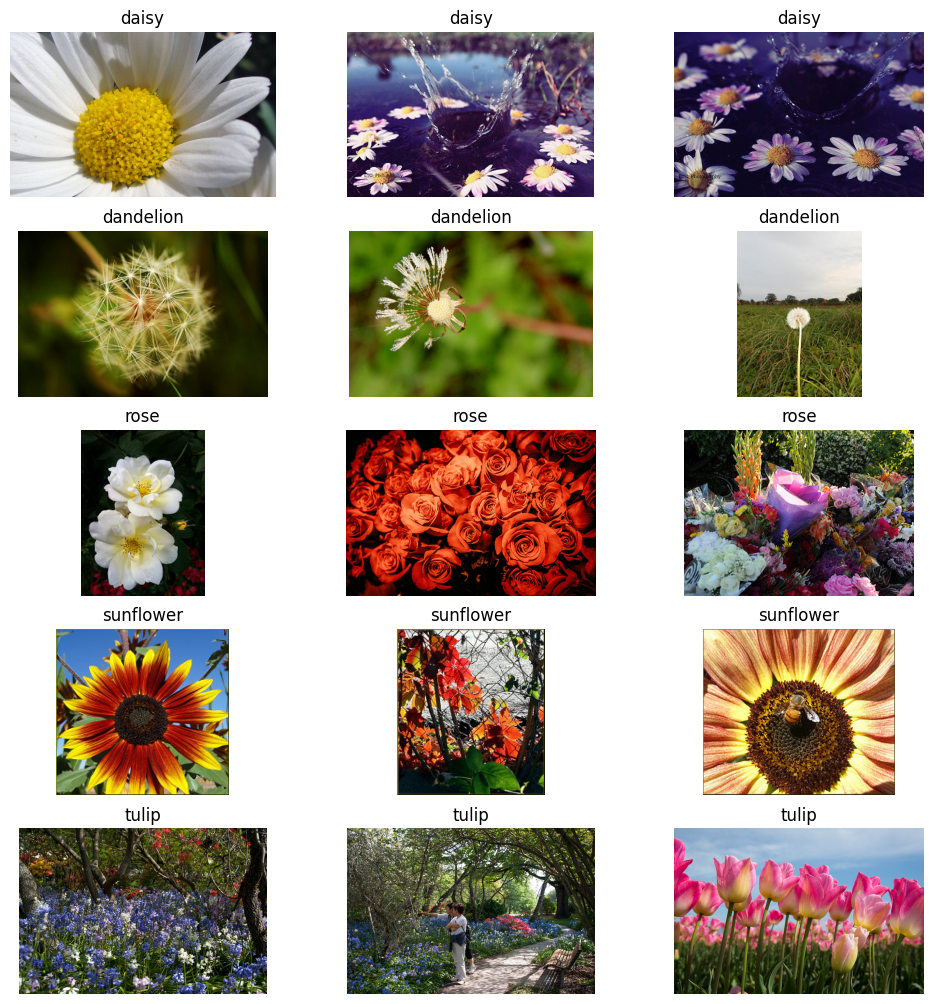

In [17]:
def show_samples(root_dir, n=3):
    classes = sorted(os.listdir(root_dir))
    plt.figure(figsize=(12, len(classes)*2.5))

    index = 1
    for cls in classes:
        cls_path = os.path.join(root_dir, cls)
        imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(("jpg","jpeg","png"))][:n]
        
        for img_name in imgs:
            img = Image.open(os.path.join(cls_path, img_name))
            plt.subplot(len(classes), n, index)
            plt.imshow(img)
            plt.title(cls)
            plt.axis("off")
            index += 1

show_samples("emotions/Data")
show_samples("fleurs/train")

On observe que dans le dataset 'emotions', certaines des images sont en noir et blanc tandis que d'autres sont en couleurs. Nous pouvons supposer que cela risque d'altérer les résultats lors de notre classification plus tard.

# Préparation données

## Pour le dataset emotions

In [96]:
img_width, img_height = 224, 224
batch_size = 16

#Classe pour 
class CustomImageDataset(Dataset):
    def __init__(self, df, path_images, transform=None):
        self.df = df.reset_index(drop=True)
        self.path_images = path_images
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = f"{self.path_images}/{self.df.loc[idx, 'image']}"
        image = Image.open(img_path).convert('RGB')
        label = self.df.loc[idx, 'class']  # pour classification catégorielle
        if self.transform:
            image = self.transform(image)
        return image, label



dataset_path = "emotions/Data"
full_dataset_emotions = datasets.ImageFolder(root=dataset_path, transform=train_transforms)

In [97]:
# --- Transformations ---
# Train sans augmentation
train_transforms = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Train avec augmentation
train_transforms_aug = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(40),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Validation / Test (pas d'augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [105]:
from sklearn.model_selection import train_test_split

#Créer un DataFrame à partir de ImageFolder
image_paths = [s[0].split('/')[-1] for s in full_dataset_emotions.samples]
labels = [s[1] for s in full_dataset_emotions.samples]

full_df_emotions = pd.DataFrame({'image': image_paths, 'class': labels})

N_total = len(full_df_emotions)
N_train = int(0.8 * N_total)
N_val_test = N_total - N_train
N_val = N_val_test // 2
N_test = N_val_test - N_val

print("Taille train :", N_train, "(", N_train/N_total*100, "% )")
print("Taille validation :", N_val, "(", N_val/N_total*100, "% )")
print("Taille test :", N_test, "(", N_test/N_total*100, "% )")

# Split des différents sets 
train_df_e, val_test_df_e = train_test_split(
    full_df_emotions,
    train_size=N_train,
    stratify=full_df_emotions['class'],
    random_state=42
)

val_df_e, test_df_e = train_test_split(
    val_test_df_e,
    train_size=N_val,
    stratify=val_test_df_e['class'],
    random_state=42
)

# --- Datasets ---
train_dataset = CustomImageDataset(train_df_e, dataset_path, transform=train_transforms)
train_dataset_aug = CustomImageDataset(train_df_e, dataset_path, transform=train_transforms_aug)
val_dataset = CustomImageDataset(val_df_e, dataset_path, transform=val_test_transforms)
test_dataset = CustomImageDataset(test_df_e, dataset_path, transform=val_test_transforms)

# --- DataLoaders ---
train_loader_e = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader_aug_e = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader_e = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_e = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)



Taille train : 47279 ( 79.99966158479839 % )
Taille validation : 5910 ( 10.000169207600806 % )
Taille test : 5910 ( 10.000169207600806 % )


train_dataset_aug contient les mêms images que train_dataset mais transformées. Seul ce dataset transform les images.

In [99]:
print(full_dataset_emotions)          
print(full_dataset_emotions.classes)   
print(len(full_dataset_emotions))     
img, label = full_dataset_emotions[0]
print(img.shape)             
print(label)

Dataset ImageFolder
    Number of datapoints: 59099
    Root location: emotions/Data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']
59099
torch.Size([3, 224, 224])
0


On voit donc que ce dataset contient 5 labels d'émotions différents, il contient 59099 images au total. Si l'on regarde la première image, on voit que cette image est de taille (3, 224, 224) (en pytorch les tailles sont (C, H, W) ) donc c'est une image RGB de taille 224x224 et la première image a le premier label donc 'Angry'.

## Pour le dataset Fleurs


In [70]:
image_size = 224

train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset_path = "fleurs/train"
full_dataset_fleurs = datasets.ImageFolder(root=dataset_path, transform=train_transforms)


N_total = len(full_dataset_fleurs)
N_train = int(0.8 * N_total)
N_val_test = N_total - N_train
N_val = N_val_test // 2
N_test = N_val_test - N_val

print("Taille train :", N_train, "(", N_train/N_total*100, "% )")
print("Taille validation :", N_val, "(", N_val/N_total*100, "% )")
print("Taille test :", N_test, "(", N_test/N_total*100, "% )")

# Split train / val / test 
train_dataset_f, val_test_dataset_f = random_split(full_dataset_fleurs, [N_train, N_val_test])
val_dataset_f, test_dataset_f = random_split(val_test_dataset_f, [N_val, N_test])

# pas d'augmentations pour les validation et test sets
val_dataset_f.dataset.transform = test_transforms
test_dataset_f.dataset.transform = test_transforms


train_loader_f = DataLoader(train_dataset_f, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader_f   = DataLoader(val_dataset_f, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_f  = DataLoader(test_dataset_f, batch_size=batch_size, shuffle=False, num_workers=2)




Taille train : 2196 ( 79.97086671522214 % )
Taille validation : 275 ( 10.01456664238893 % )
Taille test : 275 ( 10.01456664238893 % )


Regardons les informations du datset que nous avons:

In [21]:
print(full_dataset_fleurs)          
print(full_dataset_fleurs.classes)   
print(len(full_dataset_fleurs))     
img, label = full_dataset_fleurs[0]
print(img.shape)             
print(label)                  

Dataset ImageFolder
    Number of datapoints: 2746
    Root location: fleurs/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
2746
torch.Size([3, 224, 224])
0


On voit donc que ce dataset contient 5 labels de fleurs différents, il cintiznt 2746 images au total. Si l'on regarde la première image, on voit que cette image est de taille (3, 32, 32) (en pytorch le stailles sont (C, H, W) ) donc c'est une image RGB de taille 32x32 et la première image a le premier label donc 'daisy'.

In [ ]:
def prediction(model, train_generator, validation_generator):
    t_prediction = time.time()
    score_train = model.evaluate(train_generator, verbose=1)
    score_validation = model.evaluate(validation_generator,  verbose=1)
    t_prediction = time.time() - t_prediction

    print('Train accuracy:', score_train[1])
    print('Validation accuracy:', score_validation[1])
    print("Time Prediction: %.2f seconds" % t_prediction)
    

def plot_training_analysis(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, color='cadetblue', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, color='sandybrown', label='Validation accuracy')
    plt.title('Training et validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, color='cadetblue', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss, color='sandybrown', label='Validation loss')
    plt.title('Training et validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Implémentation du CNN

In [22]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # réduction de la taille par 2
        self.dropout = nn.Dropout(0.3)

        # Fully connected final
        # image_size = taille de l’image d’entrée, ici 128x128 par exemple
        self.fc = nn.Linear(256*2*2, num_classes) 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)

        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)  # flatten
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Exemple
model = EmotionCNN(num_classes=5)
model

EmotionCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=1024, out_features=5, bias=True)
)

## Entrainement pour le dataset Emotions (faire pareil pour fleurs)

In [24]:
model = EmotionCNN(num_classes=5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader_e:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    print(f"Epoch {epoch+1}/{num_epochs} — Loss: {epoch_loss:.4f} — Acc: {epoch_acc:.4f}")

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader_e:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (12x50176 and 1024x5)

In [25]:
import torchvision

# obtenir quelques images du test set
model.eval()
data_iter = iter(test_loader_e)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# afficher 8 images
plt.figure(figsize=(12,6))
for idx in range(8):
    plt.subplot(2,4,idx+1)
    img = images[idx].cpu()
    # undo normalisation pour affichage
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    img = img.clamp(0,1)
    plt.imshow(img.permute(1,2,0))
    plt.title(f"Pred: {test_dataset.dataset.classes[preds[idx]]}\nTrue: {test_dataset.dataset.classes[labels[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


NameError: name 'test_loader' is not defined

Il faudrait comparer la performance avec celle faite sans entraînement, pour voir si la partie "train" est vraiment productive. Cela nous permettra de voir de quoi on part avec le CNN comparé au ViT. 

On observe ici que la même architecture entraînée de CNN semble donner des résultats très probants (avec des accuracy autour de 97%) pour le dataset de fleurs comme pour celui des émotions. Nous allons cependant continuer notre étude de modèle en testant cette fois ci avec un ViT afin de voir si l'on obtient de meilleures performances.

# Partie Vit

## Explication de l'architecture du ViT

Les transformers ont initialement étaient inventés pour des problèmes NLP mais on peut aussi l'utiliser -comme ici- pour de la classification d'images. 

On commence par le *patch embedding* : l’image est découpée en patchs non chevauchants (par exemple de taille 16×16×3). Chaque patch est ensuite aplati en un vecteur 1D, que l’on peut appeler $patch_{flat}$. Ainsi, pour chaque patch, on obtient un vecteur de taille fixe $N$ (correspondant au nombre total de pixels multiplié par le nombre de canaux).
Cependant, ce vecteur brut n’est pas encore dans l’espace de représentation utilisé par le Transformer. Le Transformer travaille avec une dimension d’embedding fixe $D$ (par exemple, pour $ViT-Base$, $D=768$).
Pour passer de $N$ à $D$, on applique une projection linéaire : chaque vecteur $patch_{flat}$ est multiplié par une matrice de poids apprenables $W \in \mathbb{R}^{N \times D}$.
Cette transformation produit un vecteur de dimension $D$ pour chaque patch. Ces vecteurs sont alors adaptés pour être traités par le Transformer : ils capturent de manière efficace des informations sur les formes, textures, couleurs, etc., dans un espace où le modèle peut apprendre des relations globales entre les patchs.

**Qu'est ce que la matrice $W$?**

La matrice $W \in \mathbb{R}^{N \times D}$ sert à transformer un patch brut en un embedding de dimension $D$. Chaque colonne de $W$ correspond à une feature ou un filtre que le modèle apprend à détecter dans un patch, tandis que chaque ligne correspond à un pixel spécifique du patch. Cette matrice est apprise par backpropagation lors de l’entraînement. Ainsi, $W$ apprend à produire des vecteurs qui contiennent les informations visuelles les plus pertinentes pour les couches Transformer qui suivent. Chaque valeur de ces vecteurs après projection est appelée une activation. On appellera par la suite ces nouveaux vecteurs $patch_{projected}$.

**Token CLS** 

A la suite du *patch embedding*, un token spécial appelé token de classification (noté $[CLS]$) est ajouté au début de la séquence. Ce token est un vecteur apprenable, de même dimension que les $patch_{projected}$. Contrairement aux autres tokens, il ne correspond à aucun patch de l’image. Son rôle est d’agréger, via les mécanismes d’auto-attention du Transformer, les informations provenant de l’ensemble des patchs. Après le passage dans tous les blocs de l’encodeur, l’état final du token $[CLS]$ est utilisé comme représentation globale de l’image et sert d’entrée à la couche de classification finale.

**Encodage positionnel**

Après cette étape, un *encodage positionnel* est ajouté à chaque embedding de patch afin de préserver la structure spatiale de l’image originale. Ces encodages permettent au modèle de capturer les relations spatiales entre les patchs, de manière analogue à la façon dont les Transformers en traitement du langage naturel encodent la position des mots dans une phrase. Dans les Vision Transformers, les encodages positionnels peuvent être soit appris pendant l’entraînement, soit prédéfinis (fixes). La plupart des implémentations modernes utilisent des encodages positionnels appris, ce qui permet au modèle d’adapter dynamiquement les représentations des positions pour la tâche spécifique.

Une fois cette étape réalisée, les patchs sont incorporés dans l’encodeur, qui est composé de $L$ blocs identiques. Dans chaque bloc, on retrouve successivement un LayerNorm, suivi d’une Multi-Head Self-Attention, puis d’une connexion résiduelle (Add & Skip), ensuite un second LayerNorm et enfin un Feed-Forward Network. Après avoir traversé tous les blocs de l’encodeur, on obtient un embedding final qui est ensuite utilisé pour effectuer la classification finale de l’image.

**Explication du LayerNorm**

Chaque *activation* $x_i$, ’est-à-dire chaque valeur des vecteurs $patch_projected$ est d’abord normalisée en soustrayant la moyenne et en divisant par l’écart-type, ce qui donne $\hat{x_i}$. Ensuite, pour chaque valeur normalisée, on ajoute un gain et un biais, qui sont des paramètres appris par le modèle, de manière à obtenir $\gamma * \hat{x_i} + \beta$. Cette opération assure que toutes les dimensions des vecteurs sont centrées autour de zéro et présentent une variance similaire, ce qui permet aux vecteurs d’être “équilibrés”. Cette normalisation facilite le travail du Transformer, en lui permettant de mieux combiner les informations et en évitant que certaines valeurs deviennent trop grandes ou trop petites pendant l’entraînement.

**Explication du Multi-Head Attention**

Après le LayerNorm, chaque token a une taille $D$.

L’attention permet à chaque token de regarder tous les autres tokens et de décider quelles informations il doit prendre en compte pour enrichir sa propre représentation. À chaque itération (bloc encodeur), les tokens sont mis à jour. Chaque patch doit comprendre son contexte, c’est-à-dire comment il se rapporte aux autres patches. On ne prend pas tout le contenu des autres tokens de manière égale : chaque token est pondéré selon son importance pour le token courant.

*Objectif de l’attention* : pour chaque token, décider quelles informations des autres tokens sont importantes.

Pour cela, on utilise les vecteurs $Query$ $(Q)$, $Key$ $(K)$ et $Value$ $(V)$ :


- $Q$ : ce que ce token cherche chez les autres
- $K$ : ce que chaque token propose (peut être trouvé)
- $V$ : l’information que chaque token transporte réellement. V contient donc le contenu que le token peut transmettre aux autres tokens.


Les matrices $W^Q$ , $W^K$ , $W^V$ sont initialisées de manière aléatoire (souvent avec une distribution normale) et sont mises à jour pendant l’entraînement via rétropropagation. 

Ensuite, la matrice de tous les tokens est projetée via les matrices apprises $W^Q$ , $W^K$ , $W^V$ pour obtenir les $Q$, $K$ et $V$ de tous les tokens en parallèle.

On multiplie la matrice complète de tokens par $W^Q$ , $W^K$ , $W^V$ pour obtenir tous les $Q$, $K$ et $V$ en une seule opération matricielle :

$$
Q = X W^Q, \quad K = X W^K, \quad V = X W^V
$$

Après la projection, on obtient trois matrices : 
$$
Q, K, V \in \mathbb{R}^{N \times D}
$$
où chaque ligne correspond à un token et contient son vecteur $Q$, $K$ ou $V$.

- La ligne $i$ de $Q$ correspond au vecteur de ce token qui encode ce qu’il cherche chez les autres.  
- La ligne $i$ de $K$ correspond au vecteur de ce token qui encode ce qu’il propose aux autres.  
- La ligne $i$ de $V$ correspond au vecteur de ce token qui encode l’information qu’il transmet réellement.



On calcule alors le score d’attention à partir de la similarité entre $Q$ et $K$. Le résultat est une matrice $\mathbb{R}^{N \times N}$, où chaque ligne correspond à un token et chaque colonne à l’importance des autres tokens pour ce token. On applique ensuite un softmax aux scores pour obtenir les poids d’attention, qui indiquent combien chaque token doit prendre en compte chaque autre token.

Les tokens sont ensuite mis à jour en combinant les valeurs V des autres tokens pondérées par les poids d’attention. Le résultat est que chaque token devient une combinaison pondérée de tous les tokens, enrichie du contexte global.

Chaque token contient donc ses propres informations plus un mélange pondéré des informations des autres tokens, ce qui permet au ViT de capturer des relations globales entre les patches.

En résumé, le Multi-Head Attention est un mécanisme qui permet à chaque patch de “regarder” tous les autres patches, avec plusieurs heads apprenant différents types de relations, afin d’enrichir chaque token avec un contexte global.


**Explication du Add & Skip**

On ajoute l’entrée d’une sous-couche à sa sortie, c’est-à-dire que l’entrée du LayerNorm est ajoutée à la sortie de la Multi-Head Attention, et de la même manière après le Feed-Forward. Cette opération permet au bloc de n’apprendre que la différence par rapport à l’entrée, plutôt que de recalculer entièrement la transformation. De plus, dans les réseaux profonds, il peut survenir des problèmes de vanishing gradients ; l’ajout de l’entrée garantit que le gradient peut toujours circuler directement de la sortie vers l’entrée. 

En résumé, le mécanisme d’Add & Skip rend l’apprentissage plus stable et efficace, en laissant passer l’information originale tout en ajoutant uniquement ce que la sous-couche apprend de nouveau.

**Explication du Feed-Forward**

Ici chaque token est traité individuellement. Le FFN est un MLP appliqué séparément à chaque token. De manière plus détaillée, le MLP va projeté le vecteur dans une dimension plus grande afin de crée plus de liberté pour combiner et recombiner les informations. Puis il va appliquer une fonction d'activation non linéaire GELU ce qui permet au réseau de modéliser des transformations complexes. Enfin, il va projetter de nouveaux les vecteurs dans la dimension de base $D$ pour que le Add & Skip fonctionne correctement.


Après l'encodeur, les différents vecteurs sont passés dans une couche linéaire pour produire les logits de classification. Ces logits sont ensuite passé dans une fonction softmax pour faire la prédiction de classes.


Dans cette étape, chaque token est traité individuellement. Le Feed-Forward Network (FFN) est un MLP appliqué séparément à chaque token. Plus en détail, le MLP projette d’abord le vecteur dans une dimension plus grande, ce qui offre davantage de liberté pour combiner et recombiner les informations. Ensuite, une fonction d’activation non linéaire GELU est appliquée, permettant au réseau de modéliser des transformations complexes. Enfin, les vecteurs sont projetés de nouveau dans la dimension de base $D$ afin que le mécanisme d’Add & Skip fonctionne correctement.

Après le passage dans l’encodeur, les différents vecteurs sont envoyés dans une couche linéaire pour produire les logits de classification. Ces logits sont ensuite passés dans une fonction softmax pour générer la prédiction finale des classes.

## Implémentation du Vit-B/16 

In [36]:
#num_classes = 5
#model = ViT(num_classes=num_classes)
#device = "cuda" if torch.cuda.is_available() else "cpu"
#model.to(device)
#images, labels = images.to(device), labels.to(device)
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
#criterion = nn.CrossEntropyLoss()

In [57]:
#num_epochs = 5###

#for epoch in range(num_epochs):
#    model.train()
#    running_loss = 0
#   for images, labels in tqdm(train_loader_e, desc=f"Epoch {epoch+1}/{num_epochs}"):
#        images, labels = images.to(device), labels.to(device)
#        optimizer.zero_grad()
#        outputs = model(images)
#        loss = criterion(outputs, labels)
#        loss.backward()
#        optimizer.step()
#        running_loss += loss.item()
#    
#    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

# Implémentation du Vit-B/16 par transfer learning et fine-tuning

Cette architecture est déjà implémentée par PyTorch via la librairie torchvision, nous n'avons donc pas besoin de l'implémenter à la main. Il est possible d'utiliser directement le modèle pré-entrainé sur ImageNet_1k (donc avec les poids déjà entrainés) avec les poids *SWAG_LINEAR_V1* qui est une version optimisée pour un fine-tuning rapide et où seule la couche linéaire peut être entraînée. 
De plus, nous avons choisi ces poids là car les poids *IMAGENET1K_V1* donne une accuracy légèrement plus petite.
Ici on gèle les poids sauf ceux de la couche linéaire afin d'adapter le modèle à notre dataset qui a seulement 5 classes

Toutes ces informaitons ont été prises via la documentation de pytorch : https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html 

Pour ce modèle, $patch_{size}=16$.

In [47]:
weights = ViT_B_16_Weights.IMAGENET1K_SWAG_LINEAR_V1
model = vit_b_16(weights=None) #on ne charge pas les poids ici pour ne pas avoir de problèmes avec le nombre de classes


num_classes = 5
model.heads.head = nn.Linear(768, num_classes)# 768 = dimension du token CLS et de l'embedding

#Geler TOUT le modèle
for param in model.parameters():
    param.requires_grad = False

#Dégeler UNIQUEMENT la vraie tête
for param in model.heads.head.parameters():
    param.requires_grad = True

# Charger les poids du backbone uniquement
state_dict = weights.get_state_dict(progress=True)

# Supprimer les poids de la tête linéaire pour éviter le conflit
del state_dict["heads.head.weight"]
del state_dict["heads.head.bias"]

#Verification
print(model.heads.head.weight.requires_grad)

True


Cela veut dire qu'on entraîne bien la couche linéaire: ce qu'on veut.

In [49]:
optimizer = optim.Adam(model.heads.head.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

### Entraînement pour le dataset Emotions

On implémete les mêmes fonctions que dans le projet 1.

In [79]:
# --- Fonction pour prédiction / évaluation ---
def evaluate_loader(model, loader, criterion):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(loader)
    acc = 100 * correct / total
    return avg_loss, acc


# --- Fonction pour tracer le training ---
def plot_training_history(history):
    """
    history: dictionnaire avec
        history['train_loss'], history['val_loss'], 
        history['train_acc'], history['val_acc']
    """
    epochs = range(1, len(history['train_loss'])+1)

    plt.figure(figsize=(12,5))
    
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_acc'], color='cadetblue', linestyle="--", label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], color='sandybrown', label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_loss'], color='cadetblue', linestyle="--", label='Training Loss')
    plt.plot(epochs, history['val_loss'], color='sandybrown', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/5: 100%|██████████████████████████| 11820/11820 [02:51<00:00, 68.76it/s]


Train Accuracy: 47.33% | Validation Accuracy: 48.36%
Prediction time: 25.25 sec


Epoch 2/5: 100%|██████████████████████████| 11820/11820 [02:49<00:00, 69.79it/s]


Train Accuracy: 48.38% | Validation Accuracy: 49.27%
Prediction time: 25.36 sec


Epoch 3/5: 100%|██████████████████████████| 11820/11820 [02:49<00:00, 69.67it/s]


Train Accuracy: 48.26% | Validation Accuracy: 50.02%
Prediction time: 25.71 sec


Epoch 4/5: 100%|██████████████████████████| 11820/11820 [02:49<00:00, 69.61it/s]


Train Accuracy: 48.53% | Validation Accuracy: 49.66%
Prediction time: 25.42 sec


Epoch 5/5: 100%|██████████████████████████| 11820/11820 [02:50<00:00, 69.53it/s]


Train Accuracy: 49.56% | Validation Accuracy: 50.20%
Prediction time: 25.65 sec


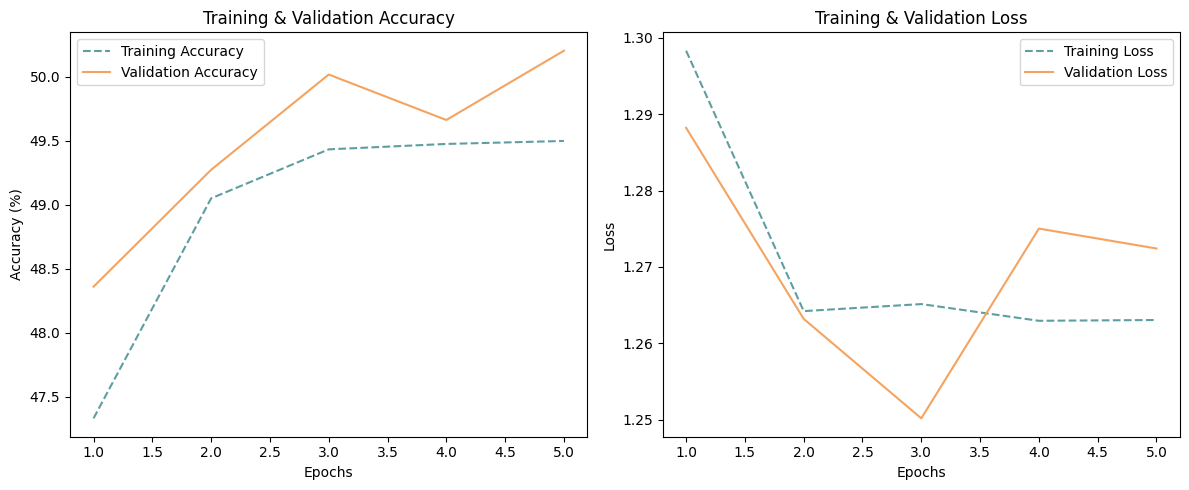

In [74]:
# Dictionnaire pour stocker l’historique
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

num_epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.head.parameters(), lr=1e-3)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
 
    
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    t_epoch = time.time()

    for images, labels in tqdm(train_loader_aug_e, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calcul de l'accuracy train
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader_aug_e)
    train_acc = 100 * correct / total

    # Validation
    val_loss, val_acc = evaluate_loader(model, val_loader_e, criterion)
    # Stocker l'historique
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    t_epoch = time.time() - t_epoch
    print(f"Epoch {epoch+1} took {t_epoch:.2f} sec")


plot_training_history(history)

In [52]:
 print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_e):.4f}")

Epoch 1, Loss: 1.6810


### Evaluation du modèle

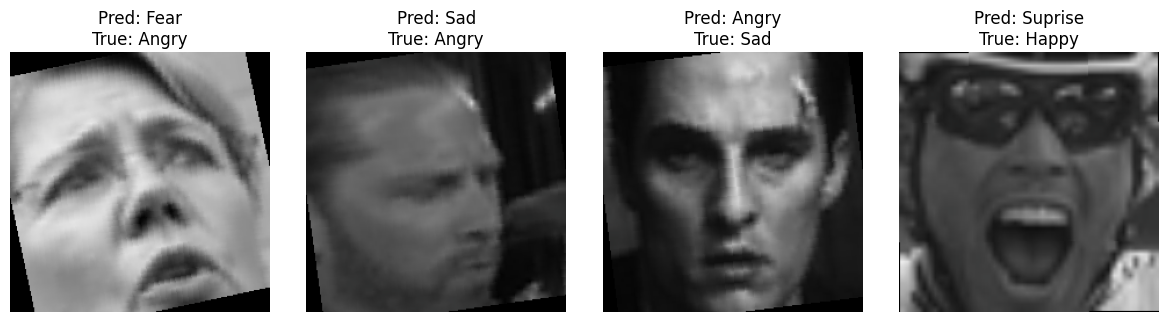

In [76]:
model.eval()
data_iter = iter(test_loader_e)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# afficher 4 images
plt.figure(figsize=(12,6))
for idx in range(4):
    plt.subplot(2,4,idx+1)
    img = images[idx].cpu()
    # undo normalisation pour affichage
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    img = img.clamp(0,1)
    plt.imshow(img.permute(1,2,0))
    plt.title(f"Pred: {test_dataset_e.dataset.dataset.classes[preds[idx]]}\nTrue: {test_dataset_e.dataset.dataset.classes[labels[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()




## Implémentation du DeiT

Comme pour le modèle précédent, il attend des images de taille 224x224 et chaque patch ets de taille 16x16.

Je degele la ciuche lineaire ainsi que les deux derniers blocs du modèle.

In [83]:
model2 = create_model('deit_tiny_patch16_224', pretrained=True, num_classes=5)

#On gèle les poids du modèle
for param in model2.parameters():
    param.requires_grad = False

for param in model2.head.parameters():  # dégele poids de la couche linéaire
    param.requires_grad = True

# Dégeler les derniers blocs
for i in [10, 11]:
    for param in model2.blocks[i].parameters():
        param.requires_grad = True

# Vérifier
trainable_params = [name for name, param in model2.named_parameters() if param.requires_grad]
print("Paramètres entraînables :", trainable_params)


criterion = nn.CrossEntropyLoss()

# Optimizer sur la tête uniquement
#optimizer = optim.Adam(model2.head.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=1e-4)


Paramètres entraînables : ['blocks.10.norm1.weight', 'blocks.10.norm1.bias', 'blocks.10.attn.qkv.weight', 'blocks.10.attn.qkv.bias', 'blocks.10.attn.proj.weight', 'blocks.10.attn.proj.bias', 'blocks.10.norm2.weight', 'blocks.10.norm2.bias', 'blocks.10.mlp.fc1.weight', 'blocks.10.mlp.fc1.bias', 'blocks.10.mlp.fc2.weight', 'blocks.10.mlp.fc2.bias', 'blocks.11.norm1.weight', 'blocks.11.norm1.bias', 'blocks.11.attn.qkv.weight', 'blocks.11.attn.qkv.bias', 'blocks.11.attn.proj.weight', 'blocks.11.attn.proj.bias', 'blocks.11.norm2.weight', 'blocks.11.norm2.bias', 'blocks.11.mlp.fc1.weight', 'blocks.11.mlp.fc1.bias', 'blocks.11.mlp.fc2.weight', 'blocks.11.mlp.fc2.bias', 'head.weight', 'head.bias']


In [82]:
for name in model2.state_dict().keys():
    print(name)

cls_token
pos_embed
patch_embed.proj.weight
patch_embed.proj.bias
blocks.0.norm1.weight
blocks.0.norm1.bias
blocks.0.attn.qkv.weight
blocks.0.attn.qkv.bias
blocks.0.attn.proj.weight
blocks.0.attn.proj.bias
blocks.0.norm2.weight
blocks.0.norm2.bias
blocks.0.mlp.fc1.weight
blocks.0.mlp.fc1.bias
blocks.0.mlp.fc2.weight
blocks.0.mlp.fc2.bias
blocks.1.norm1.weight
blocks.1.norm1.bias
blocks.1.attn.qkv.weight
blocks.1.attn.qkv.bias
blocks.1.attn.proj.weight
blocks.1.attn.proj.bias
blocks.1.norm2.weight
blocks.1.norm2.bias
blocks.1.mlp.fc1.weight
blocks.1.mlp.fc1.bias
blocks.1.mlp.fc2.weight
blocks.1.mlp.fc2.bias
blocks.2.norm1.weight
blocks.2.norm1.bias
blocks.2.attn.qkv.weight
blocks.2.attn.qkv.bias
blocks.2.attn.proj.weight
blocks.2.attn.proj.bias
blocks.2.norm2.weight
blocks.2.norm2.bias
blocks.2.mlp.fc1.weight
blocks.2.mlp.fc1.bias
blocks.2.mlp.fc2.weight
blocks.2.mlp.fc2.bias
blocks.3.norm1.weight
blocks.3.norm1.bias
blocks.3.attn.qkv.weight
blocks.3.attn.qkv.bias
blocks.3.attn.proj.wei

Epoch 1/5: 100%|█████████████████████████| 11820/11820 [01:39<00:00, 119.09it/s]


Epoch 1 took 111.59 sec


Epoch 2/5: 100%|█████████████████████████| 11820/11820 [01:38<00:00, 119.45it/s]


Epoch 2 took 111.39 sec


Epoch 3/5: 100%|█████████████████████████| 11820/11820 [01:38<00:00, 119.53it/s]


Epoch 3 took 111.22 sec


Epoch 4/5: 100%|█████████████████████████| 11820/11820 [01:39<00:00, 119.12it/s]


Epoch 4 took 111.77 sec


Epoch 5/5: 100%|█████████████████████████| 11820/11820 [01:40<00:00, 118.04it/s]


Epoch 5 took 112.59 sec


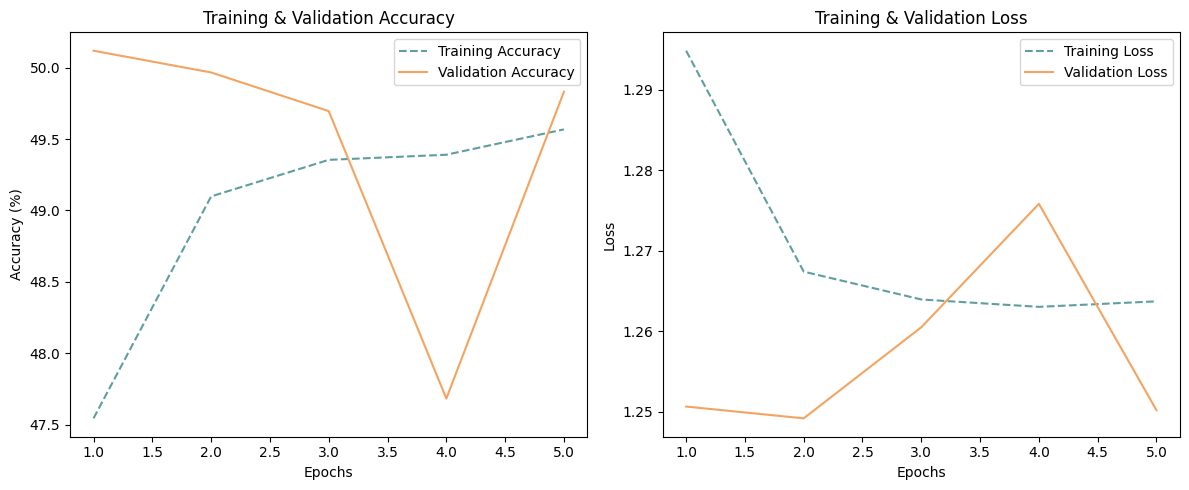

In [84]:
# Dictionnaire pour stocker l’historique
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

num_epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.head.parameters(), lr=1e-3)

device = "cuda" if torch.cuda.is_available() else "cpu"
model2.to(device)
 
    


for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    correct = 0
    total = 0
    t_epoch = time.time()

    for images, labels in tqdm(train_loader_aug_e, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calcul de l'accuracy train
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader_aug_e)
    train_acc = 100 * correct / total

    # Validation
    val_loss, val_acc = evaluate_loader(model2, val_loader_e, criterion)
    # Stocker l'historique
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    t_epoch = time.time() - t_epoch
    print(f"Epoch {epoch+1} took {t_epoch:.2f} sec")


plot_training_history(history)


In [85]:
print(train_acc)

49.56746124071998


### Evaluation du modèle

In [ ]:
model2.eval()
data_iter = iter(test_loader_e)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model2(images)
    _, preds = torch.max(outputs, 1)

# afficher 4 images
plt.figure(figsize=(12,6))
for idx in range(4):
    plt.subplot(2,4,idx+1)
    img = images[idx].cpu()
    # undo normalisation pour affichage
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    img = img.clamp(0,1)
    plt.imshow(img.permute(1,2,0))
    plt.title(f"Pred: {test_dataset_e.dataset.classes[preds[idx]]}\nTrue: {test_dataset_e.dataset.classes[labels[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()